# Obteniendo la información necesaria

In [2]:
import os.path
import numpy as np
from os import listdir
from os.path import join
from plotly import graph_objs as go
%matplotlib inline
import time
import yfinance as yf

In [2]:
# Devuelve información importante sobre la acción cuyo ticker se pase como
# parametro
def get_info_accion(ticker):
    accion=yf.Ticker(ticker)
    #hist = accion.history(period="max")["Close"]
    print(accion.info)

# Crea un archivo .csv con la información diaria sobre el activo
# cuyo ticker se pase como parametro
def guardar_accion_csv(carpeta,ticker):
    accion = yf.Ticker(ticker)
    try:
        print("Guardando información de:",ticker)
        df = accion.history(period="5y")
        time.sleep(2)
        if df.empty:
            acciones_sin_descargar.append(ticker)
        archivo = carpeta + ticker.replace(".","_")+".csv"
        print(archivo)
        df.to_csv(archivo)
    except Exception as ex:
        acciones_sin_descargar.append(ticker)
        print("No se ha podido descargar",ticker)


# Descarga los valores y crea csv para todos los tickers
# dentro de la carpeta pasada como parametro
def descargar_info_csv_carpeta(carpeta,path):
    archivos = [x for x in listdir(path) if os.path.isfile(join(path,x))]
    tickers = [os.path.splitext(x)[0] for x in archivos]
    numero_tickers = len(tickers)

    for i in range(numero_tickers):
        try:
            print("Descargando "+tickers[i]+"...")
            guardar_accion_csv(carpeta,tickers[i].replace("_","."))
        except Exception as ex:
            print("No se ha podido descargar:",tickers[i])

# Devuelve un DF de la accion correspondiente al ticker
def get_df_desde_csv(carpeta,ticker):
    return pd.read_csv(carpeta+ticker+".csv", index_col=0)

def set_retornos_diarios_al_df(df):
    df['retorno diario']= (df['Close']/df['Close'].shift(1)) - 1
    return df

def set_retornos_acumulados_al_df(df):
    df["retorno acumulado"]= (1 + df["retorno diario"]).cumprod()
    return df

def set_bandas_bollinger_al_df(df):
    df["banda_medio"] = df['Close'].rolling(window=20).mean()
    df["banda_superior"] = df['banda_medio'] + 1.96 * df['Close'].rolling(window=20).std()
    df["banda_inferior"] = df['banda_medio'] - 1.96 * df['Close'].rolling(window=20).std()
    return df

def set_ichimoku_al_df(df):
    #Linea de Conversión
    alto = df["High"].rolling(window=9).max()
    bajo = df["Low"].rolling(window=9).min()
    df["Conversion"] = (alto+bajo)/2
    #Linea Base
    alto = df["High"].rolling(window=26).max()
    bajo = df["Low"].rolling(window=26).min()
    df["Base"] = (alto+bajo)/2
    #Span A
    df["SpanA"]=((df["Conversion"] + df["Base"])/2)
    #Span B
    alto = df["High"].rolling(window=52).max()
    bajo = df["Low"].rolling(window=52).min()
    df["SpanB"]=((alto + bajo)/2).shift(26)
    #Lagging Span
    df["Lagging"] = df["Close"].shift(-26)

    return df

def set_info_df(df):
    set_retornos_diarios_al_df(df)
    set_retornos_acumulados_al_df(df)
    set_bandas_bollinger_al_df(df)
    set_ichimoku_al_df(df)

    return df


def aniadir_info_extra_stocks_carpeta(path):
    archivos = [x for x in listdir(path) if os.path.isfile(join(path,x))]
    tickers = [os.path.splitext(x)[0] for x in archivos]
    numero_tickers = len(tickers)

    for i in range(numero_tickers):
        try:
            print("Editando "+tickers[i]+"...")
            df = get_df_desde_csv(path,tickers[i])
            set_info_df(df)
            df.to_csv(path+tickers[i]+".csv")
        except Exception as ex:
            print("No se ha podido editar:",tickers[i])


# Actualiza un csv con los datos más nuevos, es decir, solo descarga los datos que faltan desde la ultima fecha guardada (CUIDADO CUANDO LOS MERCADOS ESTAN ABIERTOS)
def actualizar_csv(path,ticker):
    df_a_actualizar = pd.read_csv(path,index_col=0)
    df_a_actualizar.index = pd.to_datetime(df_a_actualizar.index)
    most_recent_date = df_a_actualizar.index.max()

    accion = yf.Ticker(ticker)
    df_nueva_info = accion.history(start=most_recent_date)

    while most_recent_date >= df_nueva_info.index.min():
        df_nueva_info.drop(axis=0,index=df_nueva_info.index[0],inplace=True)

    df_copia = df_a_actualizar.copy()
    df_copia = pd.concat([df_copia,df_nueva_info])

    ## Ahora tenemos que rellenar los datos que faltan (retornos acumulados etc)
    df_copia = set_info_df(df_copia)

    return df_copia


def actualizar_csv_carpeta(path):
    archivos = [x for x in listdir(path) if os.path.isfile(join(path,x))]
    tickers = [os.path.splitext(x)[0] for x in archivos]
    numero_tickers = len(tickers)

    for i in range(numero_tickers):
        try:
            print("Actualizando "+tickers[i]+"...")
            df_actualizar = actualizar_csv(path+tickers[i]+'.csv',tickers[i])
            time.sleep(0.1)
            df_actualizar.to_csv(path+tickers[i]+".csv")
        except Exception as ex:
            print("No se ha podido editar:",tickers[i])


def plot_candlesticks(df):
    fig = go.Figure()
    candle = go.Candlestick(x=df.index, open = df['Open'],high=df['High'],low=df['Low'],close=df["Close"],name="Candlestick")
    fig.add_trace(candle)
    fig.update_xaxes(title="Fecha",rangeslider_visible=True)
    fig.update_xaxes(title="Precio")
    fig.show()

def plot_bandas_bollinger(df,ticker):
    fig = go.Figure()

    candle = go.Candlestick(x=df.index, open=df['Open'],high=df['High'], low=df['Low'],close=df['Close'], name="Candlestick")
    upper_line = go.Scatter(x=df.index, y=df['banda_superior'],line=dict(color='rgba(250, 0, 0, 0.75)',width=1), name="Upper Band")
    mid_line = go.Scatter(x=df.index, y=df['banda_medio'],line=dict(color='rgba(0, 0, 250, 0.75)',width=0.7), name="Middle Band")
    lower_line = go.Scatter(x=df.index, y=df['banda_inferior'],line=dict(color='rgba(0, 250, 0, 0.75)',width=1), name="Lower Band")

    fig.add_trace(candle)
    fig.add_trace(upper_line)
    fig.add_trace(mid_line)
    fig.add_trace(lower_line)

    fig.update_xaxes(title="Fecha", rangeslider_visible=True)
    fig.update_yaxes(title="Precio")

    fig.update_layout(title=ticker + " Bandas Bollinger",height=1200, width=1800, showlegend=True)
    fig.show()

def color_accion(marca):
    if marca >=1:
        return 'rgba(0,250,0,0.3)'
    else:
        return 'rgba(250,0,0,0.3)'

def plot_ichimoku(df,ticker):
    fig = go.Figure()

    df_copia=df.copy()

    df['marca'] = np.where(df['SpanA']>df['SpanB'],1,0)
    df['group'] = df['marca'].ne(df['marca'].shift()).cumsum()
    df = df.groupby('group')

    dfs =[]
    for name,data in df:
        dfs.append(data)
    for df in dfs:
        fig.add_traces(go.Scatter(x=df.index,y=df['SpanA'],line=dict(color='rgba(0,0,0,0)')))
        fig.add_traces(go.Scatter(x=df.index,y=df['SpanB'],line=dict(color='rgba(0,0,0,0)'),
                                 fill='tonexty',fillcolor=color_accion(df['marca'].iloc[0])))

    candle = go.Candlestick(x=df_copia.index, open=df_copia['Open'],high=df_copia['High'], low=df_copia['Low'],close=df_copia['Close'], name="Candlestick")
    base = go.Scatter(x=df_copia.index, y=df_copia['Base'],
                      line=dict(color='pink',width=2), name="Base")
    conversion = go.Scatter(x=df_copia.index, y=df_copia['Conversion'],
                            line=dict(color='black',width=1), name="Conversión")
    span_a = go.Scatter(x=df_copia.index, y=df_copia['SpanA'],
                        line=dict(color='green',width=1), name="SpanA")
    span_b = go.Scatter(x=df_copia.index, y=df_copia['SpanB'],
                        line=dict(color='red',width=1), name="SpanB")
    lagging = go.Scatter(x=df_copia.index, y=df_copia['Lagging'],
                         line=dict(color='purple',width=1), name="Lagging")

    fig.add_trace(candle)
    fig.add_trace(conversion)
    fig.add_trace(base)
    fig.add_trace(span_a)
    fig.add_trace(span_b)
    fig.add_trace(lagging)

    fig.update_xaxes(title="Fecha", rangeslider_visible=True)
    fig.update_yaxes(title="Precio")

    fig.update_layout(title=ticker + " Ichimoku",height=1000, width=1500, showlegend=True)
    fig.show()

En este notebook vamos a incluir todo el código relativo a la obtención de la información que usaremos luego que provenga de fuentes externas, es decir, tenga que ser descargada o exportada. Si la información se ha obtenido calculandola a partir de información descargada aqui (transformaciones o ratios) no estara en este notebook.

Se incluye:
-Uso de pandas para leer URL
-Uso de yfinance para obtención de información de mercado historica

## PANDAS

In [ ]:
import os
import pandas as pd

Usamos pandas para cargar desde una URL una tabla con información sobre los constituyentes del S&P500 y otra del IBEX35, de donde obtendremos sus tickers, los cuales usaremos posteriormente para descargar su información de mercado:

### S&P500

Primero cargamos la tabla de S&P500 a un Dataframe de pandas usando la función read_html:

In [ ]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp = pd.read_html(sp_url, header=0)[0] # returns a list for each table
sp.info()

In [ ]:
sp

Tomamos la columna 'Symbol' referida al ticker de las compañias y creamos una serie de archivos .csv en donde almacenaremos la información diaria de precios de las acciones:

In [ ]:
tickers_sp500 = sp['Symbol'].tolist()
tickers_sp500

Combinamos el ticker de la compañia y el nombre para crear unos archivo de texto simple que contendran todos los constituyenes del indice.

In [ ]:
sp['Ticker,Company Name'] = sp['Symbol'] + ',' + sp['Security']

In [ ]:
sp.head()

In [ ]:
for ticker in tickers_sp500:
    open('datos/S&P500/'+ ticker + '.csv','w')

In [ ]:
df_texto = sp['Ticker,Company Name']

In [ ]:
df_texto.to_csv('s&p500.csv',index = False)

### IBEX35

In [ ]:
ibex_url = 'https://es.wikipedia.org/wiki/IBEX_35'

In [ ]:
ibex = pd.read_html(ibex_url, header=0, match='Ticker')[0]# returns a list for each table
ibex.head()

In [ ]:
ibex

In [ ]:
ibex['Ticker,Company Name'] = ibex['Ticker'] + '.MC' + ',' + ibex['Empresa']

In [ ]:
df_texto = ibex['Ticker,Company Name']

In [ ]:
tickers_ibex = ibex['Ticker'].tolist()

In [ ]:
tickers_ibex

In [ ]:
for ticker in tickers_ibex:
    open('datos/IBEX35/'+ ticker + '_MC.csv','w')

In [ ]:
df_texto.to_csv('IBEX35.csv',index = False)

# YFINANCE

### DESCARGADO INFORMACION DIARIA DE LAS ACCIONES DEL S&P500

In [ ]:
descargar_info_csv_carpeta("./datos/S&P500/","./datos/S&P500/")

In [ ]:
aniadir_info_extra_stocks_carpeta("./datos/S&P500/")

In [ ]:
actualizar_csv_carpeta("./datos/S&P500/")

### DESCARGAR DATOS SPY

In [ ]:
acciones_sin_descargar = []
path = "./datos/IBEX35/"
descargar_info_csv_carpeta(path,path)
aniadir_info_extra_stocks_carpeta(path)
df = get_df_desde_csv(path,"TEF_MC")
plot_ichimoku(df,"TEF_MC")

In [ ]:
guardar_accion_csv('SPY.csv','SPY')

### Autocorrelación parcial con retornos normales

In [ ]:
df = pd.read_csv('SPY.csv')

In [ ]:
df['retorno diario']= (df['Close']/df['Close'].shift(1)) - 1

In [ ]:
df

In [ ]:
df.set_index('Date')

In [ ]:
pd.to_datetime(df['Date'])

In [ ]:
df_retornos = df['retorno diario']*100
df_retornos

In [ ]:
df_retornos=df_retornos.to_numpy()
df_retornos=df_retornos.transpose()

In [ ]:

df_retornos=df_retornos[1:]

In [ ]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
plot_pacf(df_retornos, lags=30,title='Autocorrelación parcial')
pyplot.show()

In [ ]:
pcor = pd.DataFrame(pacf(df_retornos,nlags=40))
pcor

In [ ]:
pcor.sort_values(by=0,ascending=False,inplace=True,key=abs)
pcor

### Autocorrelación Parcial con precios

In [ ]:
df.set_index('Date',inplace=True)

In [ ]:
df

In [ ]:
df_precio = df['Close']
df_precio.plot()

In [ ]:
df_precio = df_precio.reset_index()
df_precio = df_precio['Close']

In [ ]:
df_precio

In [ ]:
pacor = pacf(df_precio,nlags=40)
df_precio = pd.DataFrame(pacor)
df_precio

In [ ]:
df_precio.sort_values(by=0,ascending=False,inplace=True,key=abs)
df_precio

In [ ]:
df = get_df_desde_csv('datos/S&P500/','AAPL')
df

In [ ]:
# Actualiza un csv con los datos más nuevos, es decir, solo descarga los datos que faltan desde la ultima fecha guardada
def update_csv(path,ticker):
    df_a_actualizar = pd.read_csv(path,index_col=0)
    df_a_actualizar.index = pd.to_datetime(df_a_actualizar.index)
    most_recent_date = df_a_actualizar.index.max()

    accion = yf.Ticker(ticker)
    df_nueva_info = accion.history(start=most_recent_date)

    while most_recent_date >= df_nueva_info.index.min():
        df_nueva_info.drop(axis=0,index=df_nueva_info.index[0],inplace=True)

    df_copia = df_a_actualizar.copy()
    df_copia = pd.concat([df_copia,df_nueva_info])

    ## Ahora tenemos que rellenar los datos que faltan (retornos acumulados etc)
    df_copia = set_info_df(df_copia)

    return df_copia


In [ ]:
df['retorno diario']= (df['Close']/df['Close'].shift(1)) - 1

In [ ]:
df

In [ ]:
df.set_index('Date')

In [ ]:
pd.to_datetime(df['Date'])

In [ ]:
df_retornos = df['retorno diario']*100
df_retornos

In [ ]:
df_retornos=df_retornos.to_numpy()
df_retornos=df_retornos.transpose()

In [ ]:

df_retornos=df_retornos[1:]

In [ ]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
plot_pacf(df_retornos, lags=30,title='Autocorrelación parcial')
pyplot.show()

In [ ]:
pcor = pd.DataFrame(pacf(df_retornos,nlags=40))
pcor

In [ ]:
pcor.sort_values(by=0,ascending=False,inplace=True,key=abs)
pcor

### Autocorrelación Parcial con precios

In [ ]:
df.set_index('Date',inplace=True)

In [ ]:
df

In [ ]:
df_precio = df['Close']
df_precio.plot()

In [ ]:
df_precio = df_precio.reset_index()
df_precio = df_precio['Close']

In [ ]:
df_precio

In [ ]:
pacor = pacf(df_precio,nlags=40)
df_precio = pd.DataFrame(pacor)
df_precio

In [ ]:
df_precio.sort_values(by=0,ascending=False,inplace=True,key=abs)
df_precio

### Añadiendo las 101 alfas

In [3]:
SPY = yf.Ticker('SPY')
data = SPY.history(period='10y')

In [4]:
data

Open        High         Low       Close     Volume  \
Date                                                                    
2012-10-15  118.662399  119.490874  118.281308  119.366608  107689100   
2012-10-16  119.929940  120.659001  119.847100  120.576149  108815500   
2012-10-17  120.659004  121.222373  120.476739  121.122948  128834100   
2012-10-18  120.808136  121.388066  120.402179  120.808136  148108500   
2012-10-19  120.584398  120.592678  118.513213  118.794891  185645200   
...                ...         ...         ...         ...        ...   
2022-10-10  363.959991  364.209991  357.670013  360.019989   76042800   
2022-10-11  358.239990  363.029999  355.709991  357.739990   92482800   
2022-10-12  358.170013  359.820007  356.299988  356.559998   76991800   
2022-10-13  349.209991  367.510010  348.109985  365.970001  147254500   
2022-10-14  368.549988  370.260010  356.959991  357.630005  123625000   

            Dividends  Stock Splits  
Date                                 
2012-10-15        0.0             0  
2012-10-16        0.0             0  
2012-10-17        0.0             0  
2012-10-18        0.0             0  
2012-10-19        0.0             0  
...               ...           ...  
2022-10-10        0.0             0  
2022-10-11        0.0             0  
2022-10-12        0.0             0  
2022-10-13        0.0             0  
2022-10-14        0.0             0  

[2517 rows x 7 columns]

In [5]:
data = data.drop(['Dividends','Stock Splits'],axis=1)

In [6]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [7]:
import utils as u
data['vwap'] = u.vwap(data)
data['returns'] = u.returns(data)

In [8]:
data

Open        High         Low       Close     Volume  \
Date                                                                    
2012-10-15  118.662399  119.490874  118.281308  119.366608  107689100   
2012-10-16  119.929940  120.659001  119.847100  120.576149  108815500   
2012-10-17  120.659004  121.222373  120.476739  121.122948  128834100   
2012-10-18  120.808136  121.388066  120.402179  120.808136  148108500   
2012-10-19  120.584398  120.592678  118.513213  118.794891  185645200   
...                ...         ...         ...         ...        ...   
2022-10-10  363.959991  364.209991  357.670013  360.019989   76042800   
2022-10-11  358.239990  363.029999  355.709991  357.739990   92482800   
2022-10-12  358.170013  359.820007  356.299988  356.559998   76991800   
2022-10-13  349.209991  367.510010  348.109985  365.970001  147254500   
2022-10-14  368.549988  370.260010  356.959991  357.630005  123625000   

                  vwap   returns  
Date                              
2012-10-15  119.366608       NaN  
2012-10-16  120.576149  0.010133  
2012-10-17  121.122948  0.004535  
2012-10-18  120.808136 -0.002599  
2012-10-19  118.794891 -0.016665  
...                ...       ...  
2022-10-10  360.019989 -0.007635  
2022-10-11  357.739990 -0.006333  
2022-10-12  356.559998 -0.003298  
2022-10-13  365.970001  0.026391  
2022-10-14  357.630005 -0.022789  

[2517 rows x 7 columns]

In [9]:
import feature_generation as fg

unavailable = [100,97,93,90,89,87,83,82,80,79,76,70,69,67,63,59,58,57,56,48]


alphas = []

for n in range(101):
    if (n+1) not in unavailable:
        name = 'alpha{}'.format(n+1)
        func = 'fg.{}'.format(name)
        temp_func = eval(func)
        data[name] = temp_func(data)

In [10]:
data

Open        High         Low       Close     Volume  \
Date                                                                    
2012-10-15  118.662377  119.490851  118.281285  119.366585  107689100   
2012-10-16  119.929910  120.658971  119.847070  120.576118  108815500   
2012-10-17  120.658981  121.222350  120.476716  121.122925  128834100   
2012-10-18  120.808128  121.388058  120.402171  120.808128  148108500   
2012-10-19  120.584468  120.592748  118.513282  118.794960  185645200   
...                ...         ...         ...         ...        ...   
2022-10-07  368.970001  373.290009  360.940002  362.790009  107680800   
2022-10-10  363.959991  364.209991  357.670013  360.019989   76042800   
2022-10-11  358.239990  363.029999  355.709991  357.739990   92482800   
2022-10-12  358.170013  359.820007  356.299988  356.559998   76848500   
2022-10-13  349.204987  362.720001  348.119995  359.700012   59311304   

                  vwap   returns    alpha1    alpha2    alpha3  ...  alpha86  \
Date                                                            ...            
2012-10-15  119.366585       NaN       NaN       NaN       NaN  ...        0   
2012-10-16  120.576118  0.010133       NaN       NaN       NaN  ...        0   
2012-10-17  121.122925  0.004535       NaN       NaN       NaN  ...        0   
2012-10-18  120.808128 -0.002599       NaN       NaN       NaN  ...        0   
2012-10-19  118.794960 -0.016664       NaN       NaN       NaN  ...        0   
...                ...       ...       ...       ...       ...  ...      ...   
2022-10-07  362.790009 -0.027894 -0.320827  0.664837  0.568331  ...        0   
2022-10-10  360.019989 -0.007635 -0.443620  0.522104  0.348150  ...        0   
2022-10-11  357.739990 -0.006333 -0.177368  0.448061  0.253000  ...       -1   
2022-10-12  356.559998 -0.003298 -0.320827  0.091517  0.019421  ...       -1   
2022-10-13  359.700012  0.008806  0.302368  0.754048 -0.326146  ...       -1   

             alpha88  alpha91   alpha92   alpha94  alpha95  alpha96   alpha98  \
Date                                                                            
2012-10-15       NaN     None       NaN       NaN    False      NaN       NaN   
2012-10-16       NaN     None       NaN       NaN    False      NaN       NaN   
2012-10-17       NaN     None       NaN       NaN    False      NaN       NaN   
2012-10-18       NaN     None       NaN       NaN    False      NaN       NaN   
2012-10-19       NaN     None       NaN       NaN    False      NaN       NaN   
...              ...      ...       ...       ...      ...      ...       ...   
2022-10-07  0.202703     None  0.842105 -0.618363    False    0.625 -0.103457   
2022-10-10  0.217806     None  1.000000 -0.382435    False    0.875 -0.094363   
2022-10-11  0.216216     None  0.947368 -0.273857     True    1.000 -0.081688   
2022-10-12  0.245628     None  0.842105 -0.143028     True    1.000 -0.057784   
2022-10-13  0.147854     None  0.571429 -0.746483     True    0.875 -0.027955   

             alpha99  alpha101  
Date                            
2012-10-15       NaN  0.581718  
2012-10-16       NaN  0.794941  
2012-10-17       NaN  0.621380  
2012-10-18       NaN  0.000000  
2012-10-19       NaN -0.860147  
...              ...       ...  
2022-10-07 -0.356830 -0.500364  
2022-10-10 -0.491770 -0.602357  
2022-10-11 -0.391358 -0.068297  
2022-10-12 -0.246914 -0.457258  
2022-10-13 -0.088889  0.718788  

[2516 rows x 88 columns]

In [10]:
data['-2 day'] = data['returns'].shift(1)
data['-4 day'] = data['returns'].shift(3)
data['-6 day'] = data['returns'].shift(5)
data['-7 day'] = data['returns'].shift(6)
data['-8 day'] = data['returns'].shift(7)
data['-9 day'] = data['returns'].shift(8)
data['-13 day'] = data['returns'].shift(12)
data['-23 day'] = data['returns'].shift(22)
data['-27 day'] = data['returns'].shift(26)

In [13]:
data['next returns'] = data['returns'].shift(-1)

In [14]:
data

Open        High         Low       Close     Volume  \
Date                                                                    
2012-10-15  118.662399  119.490874  118.281308  119.366608  107689100   
2012-10-16  119.929940  120.659001  119.847100  120.576149  108815500   
2012-10-17  120.659004  121.222373  120.476739  121.122948  128834100   
2012-10-18  120.808136  121.388066  120.402179  120.808136  148108500   
2012-10-19  120.584398  120.592678  118.513213  118.794891  185645200   
...                ...         ...         ...         ...        ...   
2022-10-10  363.959991  364.209991  357.670013  360.019989   76042800   
2022-10-11  358.239990  363.029999  355.709991  357.739990   92482800   
2022-10-12  358.170013  359.820007  356.299988  356.559998   76991800   
2022-10-13  349.209991  367.510010  348.109985  365.970001  147254500   
2022-10-14  368.549988  370.260010  356.959991  357.630005  123625000   

                  vwap   returns    alpha1    alpha2    alpha3  ...    -2 day  \
Date                                                            ...             
2012-10-15  119.366608       NaN       NaN       NaN       NaN  ...       NaN   
2012-10-16  120.576149  0.010133       NaN       NaN       NaN  ...       NaN   
2012-10-17  121.122948  0.004535       NaN       NaN       NaN  ...  0.010133   
2012-10-18  120.808136 -0.002599       NaN       NaN       NaN  ...  0.004535   
2012-10-19  118.794891 -0.016665       NaN       NaN       NaN  ... -0.002599   
...                ...       ...       ...       ...       ...  ...       ...   
2022-10-10  360.019989 -0.007635 -0.443642  0.522104  0.347362  ... -0.027894   
2022-10-11  357.739990 -0.006333 -0.177497  0.448061  0.252213  ... -0.007635   
2022-10-12  356.559998 -0.003298 -0.320899  0.091750  0.020725  ... -0.006333   
2022-10-13  365.970001  0.026391  0.302447 -0.608834  0.301627  ... -0.003298   
2022-10-14  357.630005 -0.022789  0.002006 -0.284940  0.211087  ...  0.026391   

              -4 day    -6 day    -7 day    -8 day    -9 day   -13 day  \
Date                                                                     
2012-10-15       NaN       NaN       NaN       NaN       NaN       NaN   
2012-10-16       NaN       NaN       NaN       NaN       NaN       NaN   
2012-10-17       NaN       NaN       NaN       NaN       NaN       NaN   
2012-10-18       NaN       NaN       NaN       NaN       NaN       NaN   
2012-10-19  0.010133       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-10-10 -0.002328  0.026401 -0.015464 -0.020889  0.019676 -0.008400   
2022-10-11 -0.010316  0.030987  0.026401 -0.015464 -0.020889 -0.016755   
2022-10-12 -0.027894 -0.002328  0.030987  0.026401 -0.015464 -0.009893   
2022-10-13 -0.007635 -0.010316 -0.002328  0.030987  0.026401 -0.002553   
2022-10-14 -0.006333 -0.027894 -0.010316 -0.002328  0.030987  0.019676   

             -23 day   -27 day  next returns  
Date                                          
2012-10-15       NaN       NaN      0.010133  
2012-10-16       NaN       NaN      0.004535  
2012-10-17       NaN       NaN     -0.002599  
2012-10-18       NaN       NaN     -0.016665  
2012-10-19       NaN       NaN      0.000140  
...              ...       ...           ...  
2022-10-10  0.006536  0.003138     -0.006333  
2022-10-11  0.015535 -0.010544     -0.003298  
2022-10-12  0.010748 -0.003773      0.026391  
2022-10-13 -0.043483  0.017965     -0.022789  
2022-10-14  0.003816  0.006536           NaN  

[2517 rows x 98 columns]

In [16]:
data.insert(0, 'next returns', data.pop('next returns'))

<AxesSubplot:>

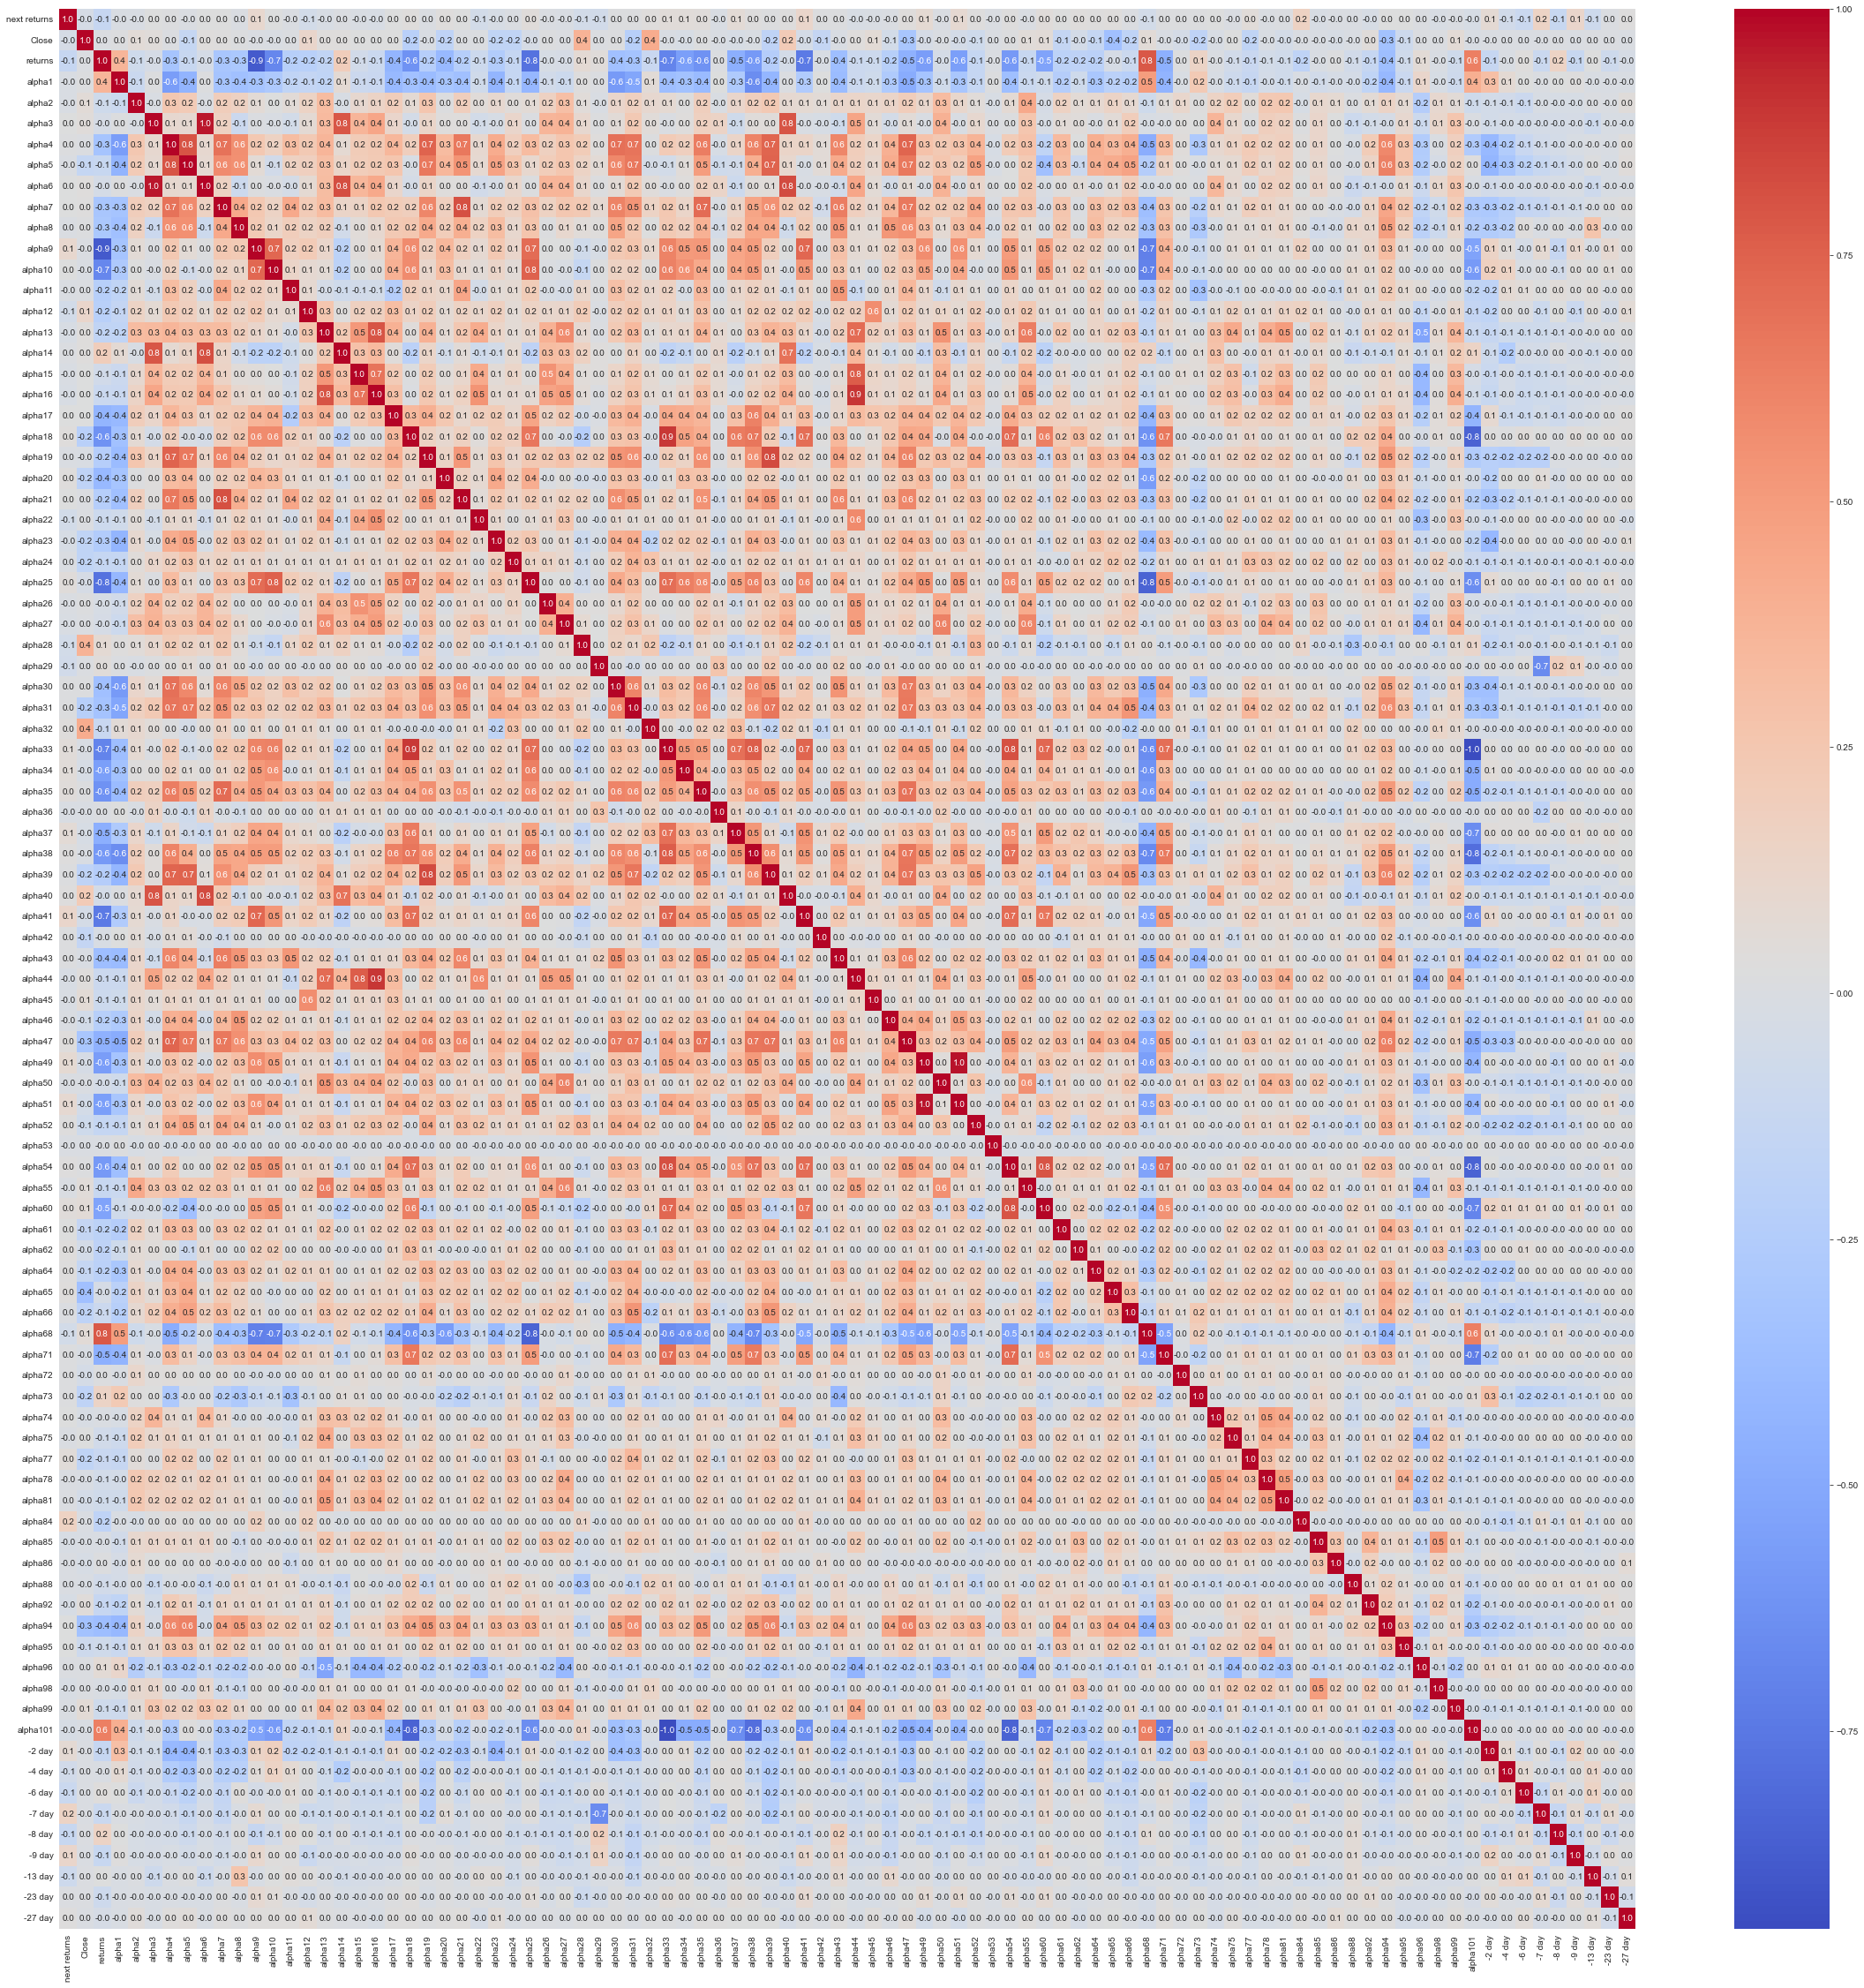

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(40,40))
sns.heatmap(data.corr(), xticklabels=1, yticklabels=1, cmap='coolwarm',annot=True,fmt='0.1f')

In [18]:
data = data.drop(['Low','Volume','High','vwap','Open'],axis=1)

In [64]:
#Funcion para eliminar variables correlacionadas con más de un umbral,
# se eliminara aquella de las dos que tenga menos correlación con la variables
# objetivo, que suponemos esta en la primera columna del DF
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_index = set()
    corr_matrix = dataset.corr()
    # Empezamos en 1 para saltarnos la variable target
    for i in range(1,len(corr_matrix.columns)):
        if(i not in corr_index):
            for j in range(1,i):
                if(j not in corr_index):
                    if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                        if corr_matrix.iloc[i, 0]>corr_matrix.iloc[j, 0]:
                            colname = corr_matrix.columns[j]  # getting the name of column
                            col_corr.add(colname)
                            corr_index.add(j)
                        else:
                            colname = corr_matrix.columns[i]  # getting the name of column
                            col_corr.add(colname)
                            corr_index.add(i)

    return list(col_corr),corr_index

In [65]:
columnas,indices = correlation(data,0.85)

In [66]:
columnas

['returns', 'alpha101', 'alpha44', 'alpha6', 'alpha49', 'alpha18']

In [67]:
indices

{2, 8, 20, 46, 50, 82}

In [69]:
data = data.drop(columnas,axis=1)

<AxesSubplot:>

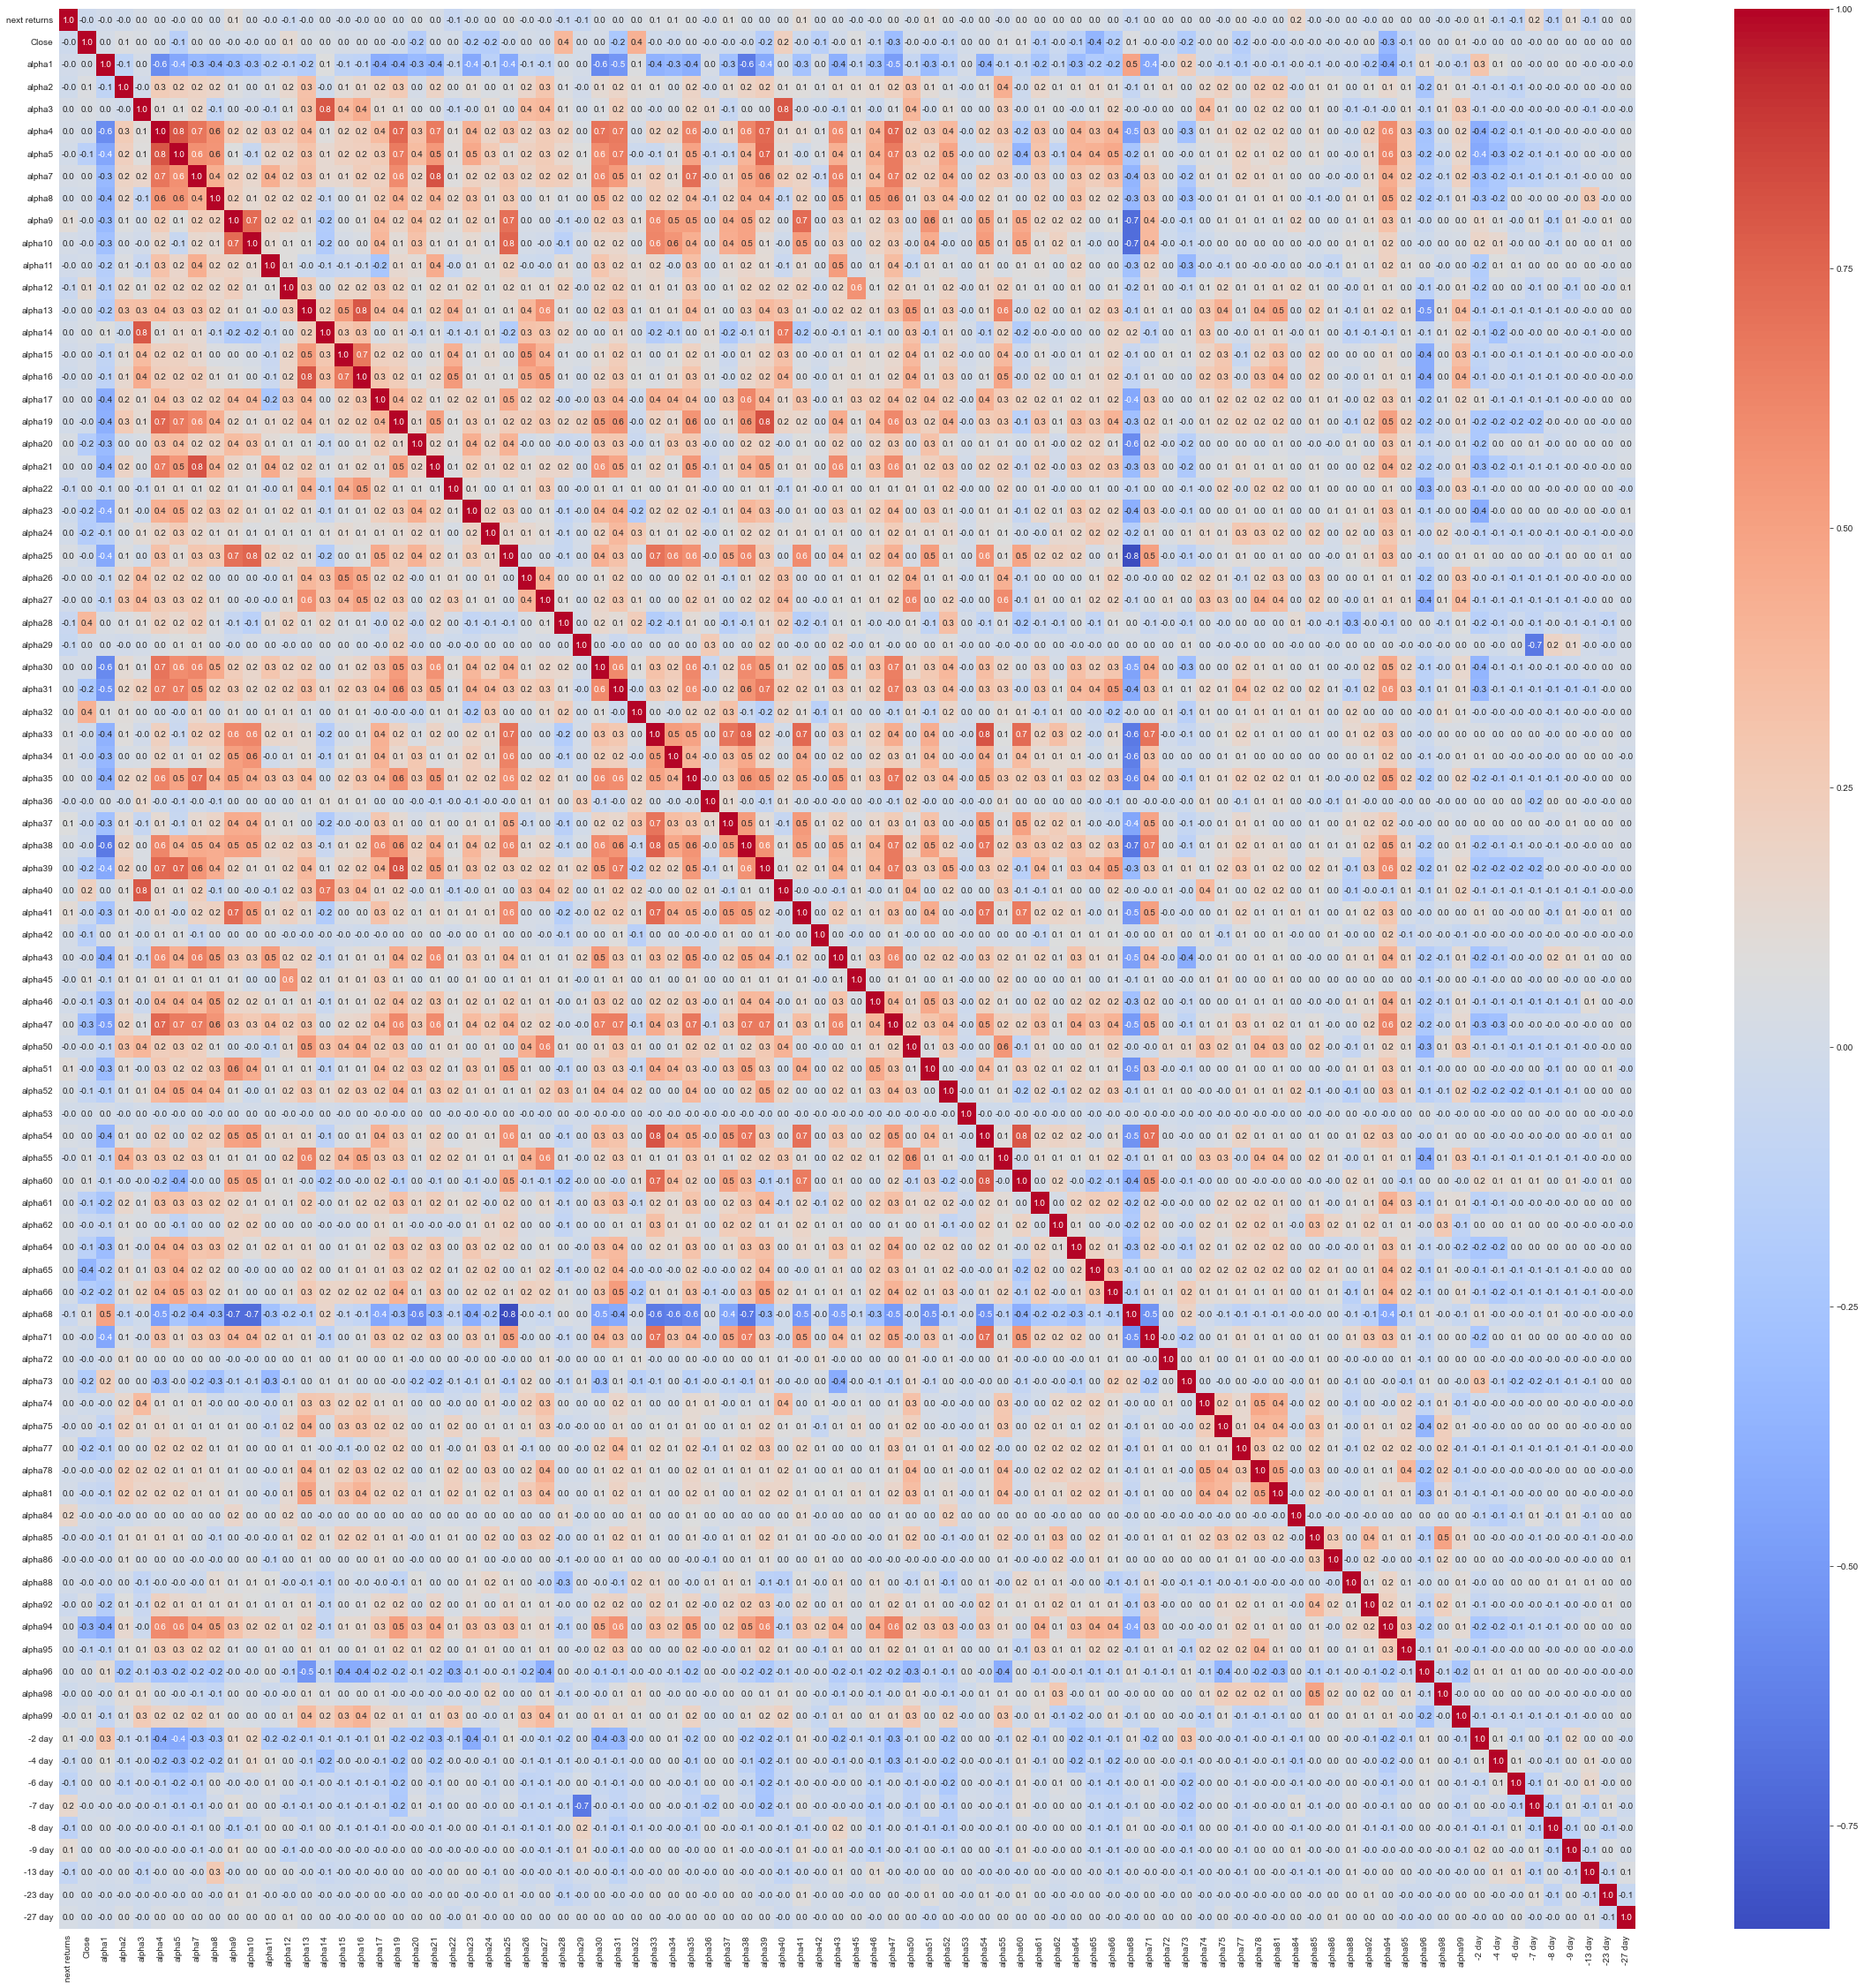

In [70]:
plt.subplots(figsize=(40,40))
sns.heatmap(data.corr(), xticklabels=1, yticklabels=1, cmap='coolwarm',annot=True,fmt='0.1f')

In [73]:
data

next returns       Close    alpha1    alpha2    alpha3    alpha4  \
Date                                                                           
2012-10-15      0.010133  119.366608       NaN       NaN       NaN       NaN   
2012-10-16      0.004535  120.576149       NaN       NaN       NaN       NaN   
2012-10-17     -0.002599  121.122948       NaN       NaN       NaN       NaN   
2012-10-18     -0.016665  120.808136       NaN       NaN       NaN       NaN   
2012-10-19      0.000140  118.794891       NaN       NaN       NaN       NaN   
...                  ...         ...       ...       ...       ...       ...   
2022-10-10     -0.006333  360.019989 -0.443642  0.522104  0.347362 -0.222222   
2022-10-11     -0.003298  357.739990 -0.177497  0.448061  0.252213 -0.111111   
2022-10-12      0.026391  356.559998 -0.320899  0.091750  0.020725 -0.222222   
2022-10-13     -0.022789  365.970001  0.302447 -0.608834  0.301627 -0.111111   
2022-10-14           NaN  357.630005  0.002006 -0.284940  0.211087 -0.444444   

              alpha5    alpha7    alpha8    alpha9  ...   alpha99    -2 day  \
Date                                                ...                       
2012-10-15       NaN -1.000000       NaN       NaN  ...       NaN       NaN   
2012-10-16       NaN -1.000000       NaN -1.209541  ...       NaN       NaN   
2012-10-17       NaN -1.000000       NaN -0.546799  ...       NaN  0.010133   
2012-10-18       NaN -1.000000       NaN  0.314812  ...       NaN  0.004535   
2012-10-19       NaN -1.000000       NaN  2.013245  ...       NaN -0.002599   
...              ...       ...       ...       ...  ...       ...       ...   
2022-10-10 -0.057439 -1.000000 -0.967626  2.770020  ... -0.491979 -0.027894   
2022-10-11 -0.018548 -1.000000 -0.566347 -2.279999  ... -0.391608 -0.007635   
2022-10-12 -0.024332 -1.000000 -0.050759 -1.179993  ... -0.247223 -0.006333   
2022-10-13 -0.004388  0.416667 -0.795364 -9.410004  ... -0.134513 -0.003298   
2022-10-14 -0.409453  0.783333 -0.839329  8.339996  ... -0.245167  0.026391   

              -4 day    -6 day    -7 day    -8 day    -9 day   -13 day  \
Date                                                                     
2012-10-15       NaN       NaN       NaN       NaN       NaN       NaN   
2012-10-16       NaN       NaN       NaN       NaN       NaN       NaN   
2012-10-17       NaN       NaN       NaN       NaN       NaN       NaN   
2012-10-18       NaN       NaN       NaN       NaN       NaN       NaN   
2012-10-19  0.010133       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-10-10 -0.002328  0.026401 -0.015464 -0.020889  0.019676 -0.008400   
2022-10-11 -0.010316  0.030987  0.026401 -0.015464 -0.020889 -0.016755   
2022-10-12 -0.027894 -0.002328  0.030987  0.026401 -0.015464 -0.009893   
2022-10-13 -0.007635 -0.010316 -0.002328  0.030987  0.026401 -0.002553   
2022-10-14 -0.006333 -0.027894 -0.010316 -0.002328  0.030987  0.019676   

             -23 day   -27 day  
Date                            
2012-10-15       NaN       NaN  
2012-10-16       NaN       NaN  
2012-10-17       NaN       NaN  
2012-10-18       NaN       NaN  
2012-10-19       NaN       NaN  
...              ...       ...  
2022-10-10  0.006536  0.003138  
2022-10-11  0.015535 -0.010544  
2022-10-12  0.010748 -0.003773  
2022-10-13 -0.043483  0.017965  
2022-10-14  0.003816  0.006536  

[2517 rows x 87 columns]

### Limpiar y Normalizar datos

In [76]:
data.dropna(axis=1,how='all',inplace=True)

In [77]:
data.dropna(axis=0,inplace=True)

In [81]:
data

next returns       Close    alpha1    alpha2    alpha3    alpha4  \
Date                                                                           
2013-10-15      0.013966  143.668335  0.002006  0.837104  0.144324 -1.000000   
2013-10-16      0.006683  145.674850  0.302447  0.630211  0.005426 -1.000000   
2013-10-17      0.006754  146.648438  0.302447  0.546596  0.036931 -1.000000   
2013-10-18      0.000057  147.638931  0.302447  0.609252  0.106372 -1.000000   
2013-10-21      0.005791  147.647400  0.302447  0.414525  0.514069 -1.000000   
...                  ...         ...       ...       ...       ...       ...   
2022-10-07     -0.007635  362.790009 -0.320899  0.664837  0.566897 -0.555556   
2022-10-10     -0.006333  360.019989 -0.443642  0.522104  0.347362 -0.222222   
2022-10-11     -0.003298  357.739990 -0.177497  0.448061  0.252213 -0.111111   
2022-10-12      0.026391  356.559998 -0.320899  0.091750  0.020725 -0.222222   
2022-10-13     -0.022789  365.970001  0.302447 -0.608834  0.301627 -0.111111   

              alpha5    alpha7    alpha8     alpha9  ...   alpha99    -2 day  \
Date                                                 ...                       
2013-10-15 -0.334463 -0.250000 -0.772182   1.049835  ... -0.445462  0.003994   
2013-10-16 -0.330275 -0.916667 -0.832934  -2.006516  ... -0.630971 -0.007254   
2013-10-17 -0.335261 -1.000000 -0.823341  -0.973587  ... -0.653264  0.013966   
2013-10-18 -0.424411 -1.000000 -0.758993  -0.990494  ... -0.732209  0.006683   
2013-10-21 -0.420821 -1.000000 -0.754596  -0.008469  ... -0.649283  0.006754   
...              ...       ...       ...        ...  ...       ...       ...   
2022-10-07 -0.305345  0.250000 -0.986411  10.410004  ... -0.356688 -0.010316   
2022-10-10 -0.057439 -1.000000 -0.967626   2.770020  ... -0.491979 -0.027894   
2022-10-11 -0.018548 -1.000000 -0.566347  -2.279999  ... -0.391608 -0.007635   
2022-10-12 -0.024332 -1.000000 -0.050759  -1.179993  ... -0.247223 -0.006333   
2022-10-13 -0.004388  0.416667 -0.795364  -9.410004  ... -0.134513 -0.003298   

              -4 day    -6 day    -7 day    -8 day    -9 day   -13 day  \
Date                                                                     
2013-10-15  0.021558 -0.011647 -0.008645  0.007577 -0.009221 -0.004597   
2013-10-16  0.006443  0.000725 -0.011647 -0.008645  0.007577 -0.005328   
2013-10-17  0.003994  0.021558  0.000725 -0.011647 -0.008645  0.007916   
2013-10-18 -0.007254  0.006443  0.021558  0.000725 -0.011647 -0.000945   
2013-10-21  0.013966  0.003994  0.006443  0.021558  0.000725 -0.009221   
...              ...       ...       ...       ...       ...       ...   
2022-10-07  0.030987 -0.015464 -0.020889  0.019676 -0.002553 -0.017444   
2022-10-10 -0.002328  0.026401 -0.015464 -0.020889  0.019676 -0.008400   
2022-10-11 -0.010316  0.030987  0.026401 -0.015464 -0.020889 -0.016755   
2022-10-12 -0.027894 -0.002328  0.030987  0.026401 -0.015464 -0.009893   
2022-10-13 -0.007635 -0.010316 -0.002328  0.030987  0.026401 -0.002553   

             -23 day   -27 day  
Date                            
2013-10-15  0.002249  0.009576  
2013-10-16  0.005787  0.007397  
2013-10-17  0.004463  0.003139  
2013-10-18  0.011574 -0.002657  
2013-10-21 -0.001676  0.002249  
...              ...       ...  
2022-10-07  0.017965 -0.007609  
2022-10-10  0.006536  0.003138  
2022-10-11  0.015535 -0.010544  
2022-10-12  0.010748 -0.003773  
2022-10-13 -0.043483  0.017965  

[2185 rows x 86 columns]

In [79]:
data.describe()

next returns        Close       alpha1       alpha2       alpha3  \
count   2185.000000  2185.000000  2185.000000  2185.000000  2185.000000   
mean       0.000434   264.141331    -0.004827     0.120593     0.258002   
std        0.011139    90.479591     0.277836     0.454387     0.388545   
min       -0.109424   143.668335    -0.443642    -0.978837    -0.895961   
25%       -0.003556   183.668213    -0.320899    -0.209727     0.010865   
50%        0.000649   247.637970     0.002006     0.150520     0.297824   
75%        0.005507   317.677032     0.302447     0.475996     0.573801   
max        0.090603   472.242310     0.302447     0.985339     0.937606   

            alpha4       alpha5       alpha7       alpha8       alpha9  ...  \
count  2185.000000  2185.000000  2185.000000  2185.000000  2185.000000  ...   
mean     -0.641953    -0.250147    -0.532403    -0.495157    -0.098024  ...   
std       0.331411     0.147935     0.686544     0.297869     3.277718  ...   
min      -1.000000    -0.500199    -1.000000    -1.000000   -20.312088  ...   
25%      -1.000000    -0.380933    -1.000000    -0.760991    -1.299820  ...   
50%      -0.777778    -0.250299    -1.000000    -0.490408    -0.096893  ...   
75%      -0.333333    -0.120861    -0.083333    -0.233813     0.903442  ...   
max      -0.111111    -0.000199     1.000000    -0.000400    28.222427  ...   

           alpha99       -2 day       -4 day       -6 day       -7 day  \
count  2185.000000  2185.000000  2185.000000  2185.000000  2185.000000   
mean     -0.332501     0.000430     0.000461     0.000395     0.000382   
std       0.238975     0.011168     0.011216     0.011207     0.011203   
min      -0.994652    -0.109424    -0.109424    -0.109424    -0.109424   
25%      -0.499204    -0.003575    -0.003597    -0.003597    -0.003585   
50%      -0.287125     0.000545     0.000595     0.000531     0.000529   
75%      -0.130810     0.005448     0.005485     0.005390     0.005363   
max      -0.000398     0.090603     0.090603     0.090603     0.090603   

            -8 day       -9 day      -13 day      -23 day      -27 day  
count  2185.000000  2185.000000  2185.000000  2185.000000  2185.000000  
mean      0.000397     0.000431     0.000497     0.000510     0.000521  
std       0.011210     0.011193     0.011165     0.011126     0.011091  
min      -0.109424    -0.109424    -0.109424    -0.109424    -0.109424  
25%      -0.003623    -0.003583    -0.003536    -0.003499    -0.003477  
50%       0.000544     0.000630     0.000602     0.000649     0.000636  
75%       0.005448     0.005457     0.005519     0.005485     0.005457  
max       0.090603     0.090603     0.090603     0.090603     0.090603  

[8 rows x 83 columns]

Cambiamos las variables categoricas binarias por su representacoón numérica:

In [83]:
data.replace({False: 0, True: 1}, inplace=True)

Añadimos una nueva versión de la variable objetivo para el caso de clasificación:
-Si el retorno en el siguiente periodo es positivo, 1
-Si el retorno en el siguiente periodo es negativo, 0

In [84]:
data['next movement'] = np.where(data['next returns']>0,1,0)

In [87]:
data.insert(0, 'next movement', data.pop('next movement'))

In [88]:
data

next movement  next returns       Close    alpha1    alpha2  \
Date                                                                      
2013-10-15              1      0.013966  143.668335  0.002006  0.837104   
2013-10-16              1      0.006683  145.674850  0.302447  0.630211   
2013-10-17              1      0.006754  146.648438  0.302447  0.546596   
2013-10-18              1      0.000057  147.638931  0.302447  0.609252   
2013-10-21              1      0.005791  147.647400  0.302447  0.414525   
...                   ...           ...         ...       ...       ...   
2022-10-07              0     -0.007635  362.790009 -0.320899  0.664837   
2022-10-10              0     -0.006333  360.019989 -0.443642  0.522104   
2022-10-11              0     -0.003298  357.739990 -0.177497  0.448061   
2022-10-12              1      0.026391  356.559998 -0.320899  0.091750   
2022-10-13              0     -0.022789  365.970001  0.302447 -0.608834   

              alpha3    alpha4    alpha5    alpha7    alpha8  ...   alpha99  \
Date                                                          ...             
2013-10-15  0.144324 -1.000000 -0.334463 -0.250000 -0.772182  ... -0.445462   
2013-10-16  0.005426 -1.000000 -0.330275 -0.916667 -0.832934  ... -0.630971   
2013-10-17  0.036931 -1.000000 -0.335261 -1.000000 -0.823341  ... -0.653264   
2013-10-18  0.106372 -1.000000 -0.424411 -1.000000 -0.758993  ... -0.732209   
2013-10-21  0.514069 -1.000000 -0.420821 -1.000000 -0.754596  ... -0.649283   
...              ...       ...       ...       ...       ...  ...       ...   
2022-10-07  0.566897 -0.555556 -0.305345  0.250000 -0.986411  ... -0.356688   
2022-10-10  0.347362 -0.222222 -0.057439 -1.000000 -0.967626  ... -0.491979   
2022-10-11  0.252213 -0.111111 -0.018548 -1.000000 -0.566347  ... -0.391608   
2022-10-12  0.020725 -0.222222 -0.024332 -1.000000 -0.050759  ... -0.247223   
2022-10-13  0.301627 -0.111111 -0.004388  0.416667 -0.795364  ... -0.134513   

              -2 day    -4 day    -6 day    -7 day    -8 day    -9 day  \
Date                                                                     
2013-10-15  0.003994  0.021558 -0.011647 -0.008645  0.007577 -0.009221   
2013-10-16 -0.007254  0.006443  0.000725 -0.011647 -0.008645  0.007577   
2013-10-17  0.013966  0.003994  0.021558  0.000725 -0.011647 -0.008645   
2013-10-18  0.006683 -0.007254  0.006443  0.021558  0.000725 -0.011647   
2013-10-21  0.006754  0.013966  0.003994  0.006443  0.021558  0.000725   
...              ...       ...       ...       ...       ...       ...   
2022-10-07 -0.010316  0.030987 -0.015464 -0.020889  0.019676 -0.002553   
2022-10-10 -0.027894 -0.002328  0.026401 -0.015464 -0.020889  0.019676   
2022-10-11 -0.007635 -0.010316  0.030987  0.026401 -0.015464 -0.020889   
2022-10-12 -0.006333 -0.027894 -0.002328  0.030987  0.026401 -0.015464   
2022-10-13 -0.003298 -0.007635 -0.010316 -0.002328  0.030987  0.026401   

             -13 day   -23 day   -27 day  
Date                                      
2013-10-15 -0.004597  0.002249  0.009576  
2013-10-16 -0.005328  0.005787  0.007397  
2013-10-17  0.007916  0.004463  0.003139  
2013-10-18 -0.000945  0.011574 -0.002657  
2013-10-21 -0.009221 -0.001676  0.002249  
...              ...       ...       ...  
2022-10-07 -0.017444  0.017965 -0.007609  
2022-10-10 -0.008400  0.006536  0.003138  
2022-10-11 -0.016755  0.015535 -0.010544  
2022-10-12 -0.009893  0.010748 -0.003773  
2022-10-13 -0.002553 -0.043483  0.017965  

[2185 rows x 87 columns]

<AxesSubplot:>

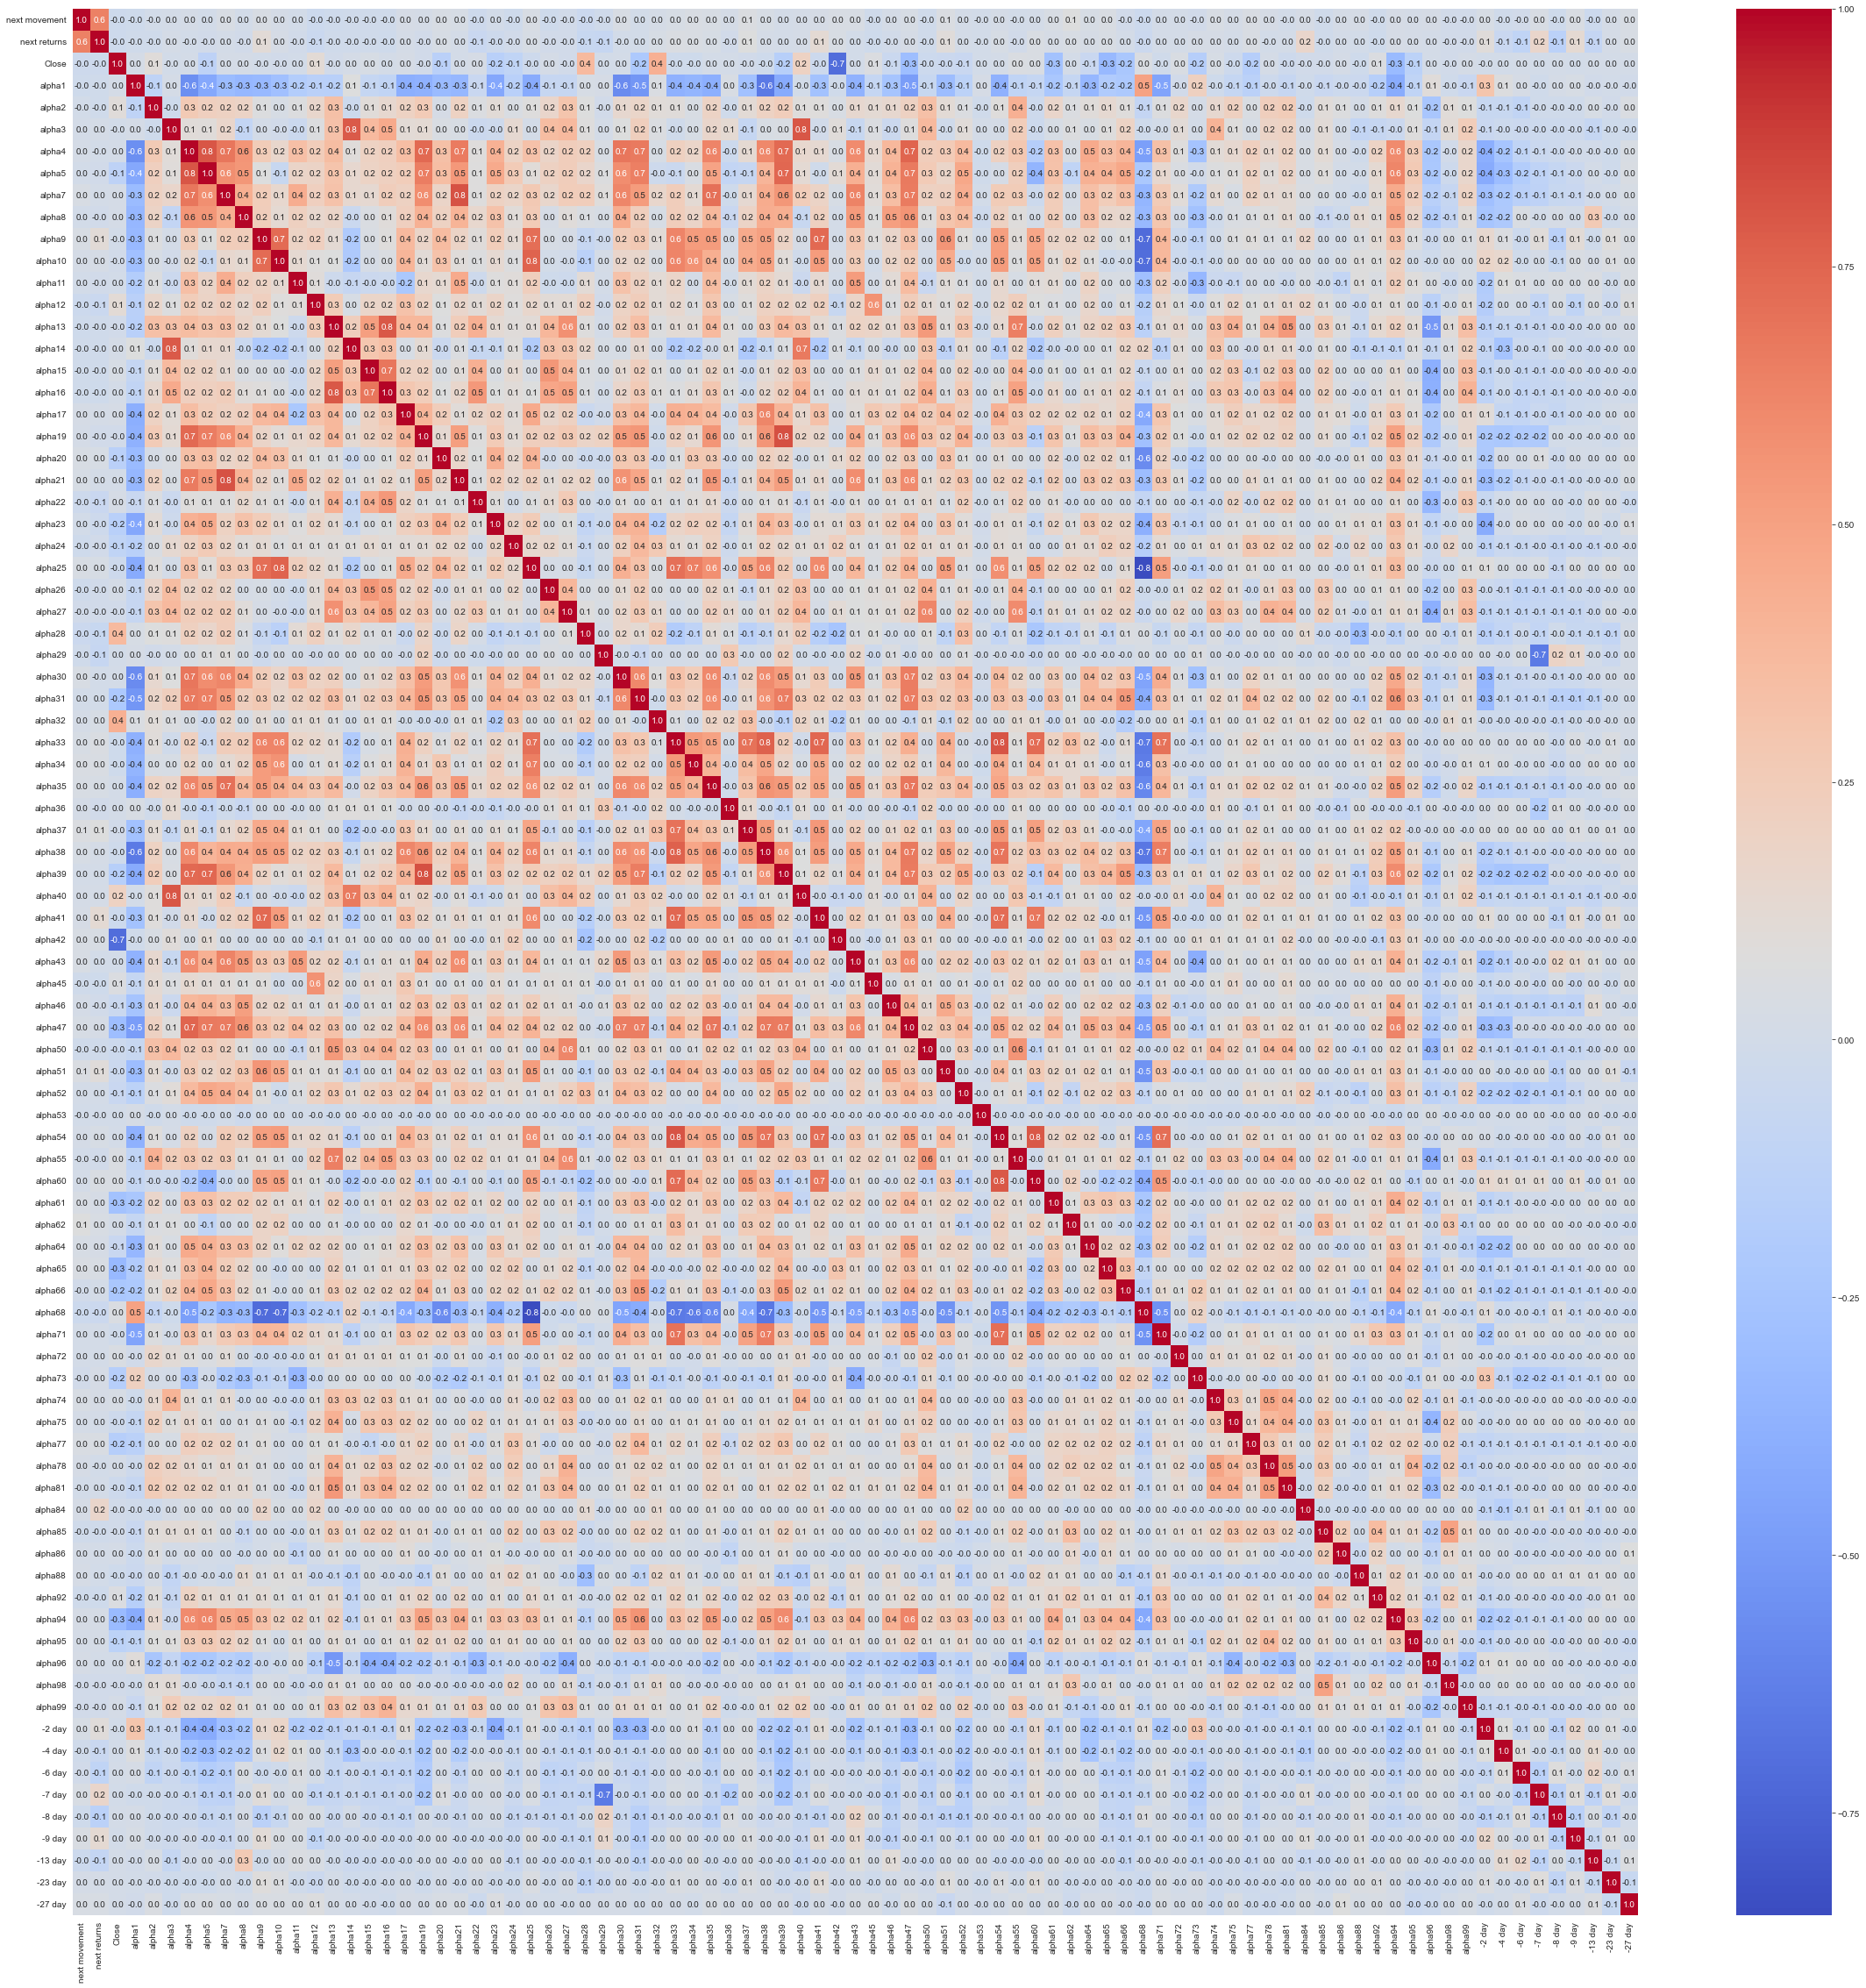

In [89]:
plt.subplots(figsize=(40,40))
sns.heatmap(data.corr(), xticklabels=1, yticklabels=1, cmap='coolwarm',annot=True,fmt='0.1f')

In [90]:
data.to_csv('spyconalfas.csv')